In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [12]:
df=pd.read_csv('asthma_disease_data.csv')
df1=df

In [34]:
continuous_columns = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']
categorical_columns = ['Gender', 'Smoking']
median_imputer = SimpleImputer(strategy='median')
df[continuous_columns] = median_imputer.fit_transform(df[continuous_columns])


mode_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = mode_imputer.fit_transform(df[categorical_columns])

scaler = MinMaxScaler()
df[continuous_columns] = scaler.fit_transform(df[continuous_columns])

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in continuous_columns:
    df = remove_outliers(df, col)
df2=df.drop(columns=['Diagnosis','DoctorInCharge'], axis=1)
corr_matrix = df2.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
df_clean = df2.drop(columns=to_drop)

In [35]:
# print(X.columns)
# print(y.shape)
y = df1['Diagnosis']
X=df_clean
print(X.columns)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print(X_res.shape)
print(y_res.shape)
print(y_res.value_counts())


Index(['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
       'Smoking', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
       'PollutionExposure', 'PollenExposure', 'DustExposure', 'PetAllergy',
       'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema', 'HayFever',
       'GastroesophagealReflux', 'LungFunctionFEV1', 'LungFunctionFVC',
       'Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing',
       'NighttimeSymptoms', 'ExerciseInduced'],
      dtype='object')
(4536, 27)
(4536,)
Diagnosis
0    2268
1    2268
Name: count, dtype: int64


In [36]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def scores(y_test, pred):
    print("Accuracy: ",accuracy_score(y_test, pred))
    print("Precision: ",precision_score(y_test, pred))
    print("Recall: ",recall_score(y_test, pred))
    print("F1 Score: ",f1_score(y_test, pred))
    print("ROC AUC Score: ",roc_auc_score(y_test, pred))
    cm = confusion_matrix(y_test, pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


Accuracy:  0.9809104258443465
Precision:  0.9698795180722891
Recall:  0.9907692307692307
F1 Score:  0.9802130898021308
ROC AUC Score:  0.9813396715643906
[[346  10]
 [  3 322]]


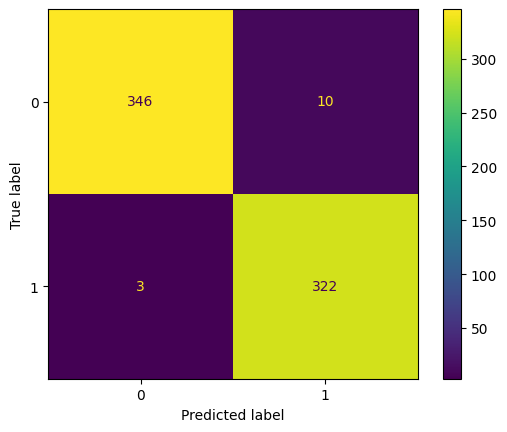

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=42)
clf=RandomForestClassifier(random_state=20)
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
# print(pred.shape)
scores(y_test, pred)

Accuracy:  0.973568281938326
Precision:  0.9694189602446484
Recall:  0.9753846153846154
F1 Score:  0.9723926380368099
ROC AUC Score:  0.9736473638720831
[[346  10]
 [  8 317]]


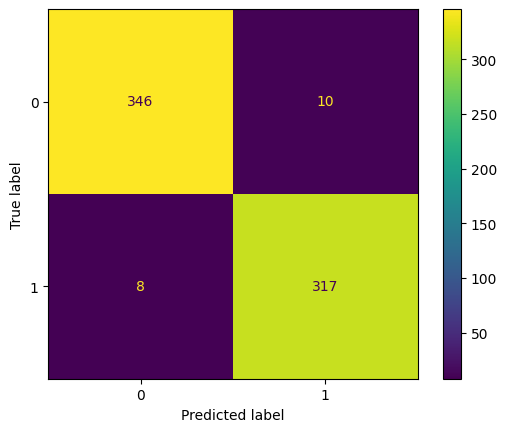

In [38]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier(random_state=20)
model.fit(X_train,y_train)
pred=model.predict(X_test)
scores(y_test, pred)


Accuracy:  0.8766519823788547
Precision:  0.8640483383685801
Recall:  0.88
F1 Score:  0.8719512195121951
ROC AUC Score:  0.8767977528089888
[[311  45]
 [ 39 286]]


c:\Users\Samridh Gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


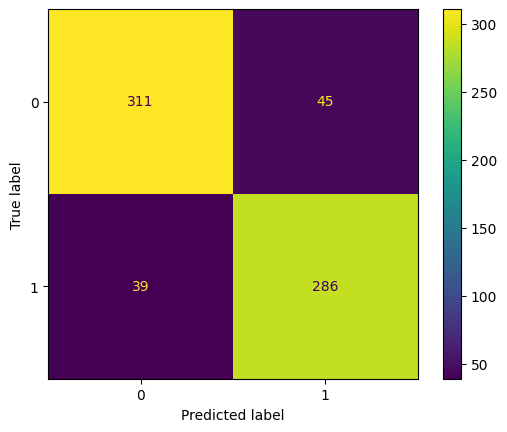

In [39]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
scores(y_test, pred)

Accuracy:  0.9324522760646109
Precision:  0.876010781671159
Recall:  1.0
F1 Score:  0.9339080459770115
ROC AUC Score:  0.9353932584269663
[[310  46]
 [  0 325]]


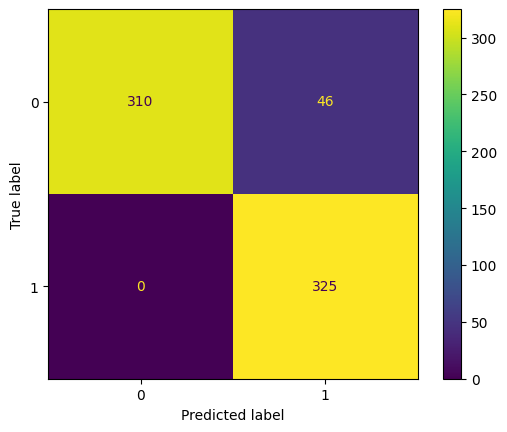

In [40]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)
scores(y_test, pred)